In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from ccdproc import Combiner
from ccdproc import wcs_project

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]
np.printoptions(suppress=True)

In [2]:
'''Here are some functions piped from Bernstein's transform.c, part of orbfit'''
#/*** Go between ecliptic coords & tangent-plane system at
#*** lat0, lon0 aligned with ecliptic.   keep the center
#*** of projection as static variables to update as needed
#****/

def check_latlon0(lat0, lon0):
    '''
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    clat0 = np.cos(lat0)
    slat0 = np.sin(lat0)
    clon0 = np.cos(lon0)
    slon0 = np.sin(lon0)
    
    return clat0, slat0, clon0, slon0

def ec_to_proj(lat_ec, lon_ec, lat0, lon0):
    '''
    First routine goes from ecliptic lat/lon to projected x/y angles
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)
    cdlon = np.cos(lon_ec - lon0)
    sdlon = np.sin(lon_ec - lon0)
    clat  = np.cos(lat_ec)
    slat  = np.sin(lat_ec)

    xp = clat * sdlon
    yp = clat0*slat - slat0*clat*cdlon
    zp = slat0*slat + clat0*clat*cdlon

    x_proj = xp/zp
    y_proj = yp/zp

    return x_proj, y_proj


def proj_to_ec(x_proj, y_proj, lat0, lon0):
    '''
    Now the inverse, from projected xy to ecliptic lat/lon
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    zp = 1./np.sqrt(1 + x_proj*x_proj + y_proj*y_proj)
    lat_ec = np.arcsin( zp* (slat0 + y_proj*clat0) )
    lon_ec = lon0 + np.arcsin( x_proj * zp / np.cos(lat_ec) )

    return lat_ec, lon_ec

def xyz_ec_to_proj(x_ec, y_ec, z_ec, lat0, lon0):
    '''
    Next go from x,y,z in ecliptic orientation to x,y,z in tangent-point orientiation.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_p = -slon0 * x_ec + clon0 * y_ec
    y_p = -clon0*slat0*x_ec - slon0*slat0*y_ec + clat0*z_ec
    z_p =  clon0*clat0*x_ec + slon0*clat0*y_ec + slat0*z_ec

    return x_p, y_p, z_p

def xyz_proj_to_ec(x_p, y_p, z_p, lat0, lon0):
    '''
    And finally from tangent x,y,z to ecliptic x,y,z.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.  
    '''
    clat0, slat0, clon0, slon0 = check_latlon0(lat0, lon0)

    x_ec =-slon0 *x_p - clon0*slat0*y_p + clon0*clat0*z_p
    y_ec = clon0 *x_p - slon0*slat0*y_p + slon0*clat0*z_p
    z_ec = clat0 * y_p + slat0 * z_p

    return x_ec, y_ec, z_ec

In [3]:
'''Here are some functions piped from Bernstein's transform.c, part of orbfit'''
#/*      $Id: transforms.c,v 2.0 2001/09/14 19:05:06 garyb Exp $  */
#
##ifndef lint
#static char vcid[] = "$Id: transforms.c,v 2.0 2001/09/14 19:05:06 garyb Exp $";
##endif /* lint */
#/*********** Coordinate transformation routines *************/
#/* All angles assumed to be in radians upon input */
#
##include "orbfit.h"
##define ECL     (23.43928*PI/180.)      /*Obliquity of ecliptic at J2000*/
ECL = np.radians(23.43928)

#
def eq_to_ec(ra_eq, dec_eq):
    '''
    First takes RA,DEC in equatorial to ecliptic.
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
#/* First takes RA,DEC in equatorial to ecliptic */
#void
#eq_to_ec( double ra_eq,
#          double dec_eq,
#          double *lat_ec,
#          double *lon_ec,
#          double **partials)
#{
#  double        sd,cd,cr,se,ce,y,x;
#
#  se = sin(ECL);
    se = np.sin(ECL)
#  ce = cos(ECL);
    ce = np.cos(ECL)
#
#  sd = ce * sin(dec_eq) - se * cos(dec_eq)*sin(ra_eq);
    sd = ce * np.sin(dec_eq) - se * np.cos(dec_eq)*np.sin(ra_eq)
#  *lat_ec = asin(sd);
    lat_ec = np.arcsin(sd)
#
#  y = ce*cos(dec_eq)*sin(ra_eq) + se*sin(dec_eq);
    y = ce*np.cos(dec_eq)*np.sin(ra_eq) + se*np.sin(dec_eq)
#  x = cos(dec_eq)*cos(ra_eq);
    x = np.cos(dec_eq)*np.cos(ra_eq)
#  *lon_ec = atan2(y,x);
    lon_ec = np.arctan2(y,x)
#
#  if (partials!=NULL) {
#    cd = sqrt(1.-sd*sd);
#    /* form Jacobian matrix  (assume not at pole)*/
#    partials[1][1] = -se*cos(dec_eq)*cos(ra_eq)/cd;
#    partials[1][2] = (ce*cos(dec_eq)+se*sin(dec_eq)*sin(ra_eq)) / cd;
#    partials[2][1] = cos(dec_eq)*partials[1][2] / cd;
#    partials[2][2] = se*cos(ra_eq) / (cd*cd);
#  }
#  
#  return;
#}
    return lat_ec, lon_ec

def xyz_eq_to_ec(x_eq, y_eq, z_eq):
    '''
    And transform x,y,z from eq to ecliptic
    
    This function is adapted from Bernstein's transform.c, part of orbfit.
    '''
#/* And transform x,y,z from eq to ecliptic */
#void
#xyz_eq_to_ec(double x_eq, double y_eq, double z_eq,
#             double *x_ec, double *y_ec, double *z_ec,
#             double **partials)
#{
#  double        se,ce;
#
#  se = sin(ECL);
    se = np.sin(ECL)
#  ce = cos(ECL);
    ce = np.cos(ECL)
#
#  *x_ec = x_eq;
    x_ec = x_eq
#  *y_ec = ce*y_eq + se*z_eq;
    y_ec = ce*y_eq + se*z_eq
#  *z_ec = -se*y_eq + ce*z_eq;
    z_ec = -se*y_eq + ce*z_eq
#
#  if (partials!=NULL) {
#    partials[1][1] = 1.;
#    partials[1][2] = partials[1][3] =
#      partials[2][1] = partials[3][1] = 0.;
#    partials[2][2] = partials[3][3] = ce;
#    partials[2][3] = se;
#    partials[3][2] = -se;
#  }
#
#  return;
#}
    return x_ec, y_ec, z_ec

def ec_to_eq(lat_ec, lon_ec):
    '''
    And transform x,y,z from eq to ecliptic.
    
    To reverse above, just flip sign of ECL effectively.
    '''
#/**To reverse above, just flip sign of ECL effectively: ***/
#void
#ec_to_eq( double lat_ec,
#          double lon_ec,
#          double *ra_eq,
#          double *dec_eq,
#          double **partials)
#{
#  double        sd,cd,cr,se,ce,y,x;
#
#  se = sin(-ECL);
    se = np.sin(-ECL)
#  ce = cos(ECL);
    ce = np.cos(ECL)
#
#  sd = ce * sin(lat_ec) - se * cos(lat_ec)*sin(lon_ec);
    sd = ce * np.sin(lat_ec) - se * np.cos(lat_ec)*np.sin(lon_ec)
#  *dec_eq = asin(sd);
    dec_eq = np.arcsin(sd)
#
#  y = ce*cos(lat_ec)*sin(lon_ec) + se*sin(lat_ec);
    y = ce*np.cos(lat_ec)*np.sin(lon_ec) + se*np.sin(lat_ec)
#  x = cos(lat_ec)*cos(lon_ec);
    x = np.cos(lat_ec)*np.cos(lon_ec)
#  *ra_eq = atan2(y,x);
    ra_eq = np.arctan2(y,x)
#
#  if (partials!=NULL) {
#    cd = sqrt(1.-sd*sd);
#    /* form Jacobian matrix  (assume not at pole)*/
#    partials[2][2] = -se*cos(lat_ec)*cos(lon_ec)/cd;
#    partials[2][1] = (ce*cos(lat_ec)+se*sin(lat_ec)*sin(lon_ec)) / cd;
#    partials[1][2] = cos(lat_ec)*partials[2][1] / cd;
#    partials[1][1] = se*cos(lon_ec) / (cd*cd);
#  }
#
#  return;
#}
    return ra_eq, dec_eq

def xyz_ec_to_eq(x_ec, y_ec, z_ec):
    '''
    And transform x,y,z from ecliptic to eq.
    
    To reverse above, just flip sign of ECL effectively.
    '''
#/* And transform x,y,z from ecliptic to eq */
#void
#xyz_ec_to_eq(double x_ec, double y_ec, double z_ec,
#             double *x_eq, double *y_eq, double *z_eq,
#             double **partials)
#{
#  double        se,ce;
#
#  se = sin(-ECL);
    se = np.sin(-ECL);
    ce = np.cos(ECL);
#  ce = cos(ECL);
#
#  *x_eq = x_ec;
    x_eq = x_ec
#  *y_eq = ce*y_ec + se*z_ec;
    y_eq = ce*y_ec + se*z_ec
#  *z_eq = -se*y_ec + ce*z_ec;
    z_eq = -se*y_ec + ce*z_ec
#
#  if (partials!=NULL) {
#    partials[1][1] = 1.;
#    partials[1][2] = partials[1][3] =
#      partials[2][1] = partials[3][1] = 0.;
#    partials[2][2] = partials[3][3] = ce;
#    partials[2][3] = se;
#    partials[3][2] = -se;
#  }
#
#  return;
#}
    return x_eq, y_eq, z_eq

In [4]:
def radec_to_proj_matrix(radec_ref=np.array([0., 0.])):
    '''This routine returns the 3-D rotation matrix for the
    given reference ra & dec.
    # matrix is a rotation matrix that converts from ecliptic
    # vectors to the projection coordinate system.
    # The projection coordinate system has z outward,
    # x parallel to increasing ecliptic longitude, and
    # y northward, making a right-handed system
    '''
    coord_ref = SkyCoord(ra=radec_ref[0] * u.deg, dec=radec_ref[1] * u.deg)
    x_ref, y_ref, z_ref = coord_ref.cartesian.xyz.value
    r = np.sqrt(x_ref * x_ref + y_ref * y_ref + z_ref * z_ref)
    lon0 = np.arctan2(y_ref, x_ref)
    lat0 = np.arcsin(z_ref / r)
    slon0 = np.sin(lon0)
    clon0 = np.cos(lon0)
    slat0 = np.sin(lat0)
    clat0 = np.cos(lat0)
   
    matrix = np.array([[-slon0, clon0, 0], 
                    [-clon0 * slat0, -slon0 * slat0, clat0],
                    [clon0 * clat0, slon0 * clat0, slat0]])
    print(np.dot(matrix,coord_ref.cartesian.xyz.value))
    return matrix

def get_heliocentric_equatorial_XYZ_from_JPL(times, obs_code='500',
                                            verbose=False):
    '''
    Query horizons for the EQUATORIAL heliocentric
    observatory position at a sequence of times.

    input:
    obs_code    - string
                - Note that Horizons uses some weird ones sometimes,
                  like "500@-95" for Tess.
    times       - array of JD times (UTC)
    '''
    from astroquery.jplhorizons import Horizons
    times_AP = Time(times, format='jd', scale='utc')
    # convert times to tdb, the time system used by Horizons for vectors. 
    times_tdb = times_AP.tdb.value
    horizons_query = Horizons(id='10', location=obs_code,
                              epochs=times_tdb, id_type='id')
    horizons_vector = horizons_query.vectors(refplane='earth')
    helio_OBS_equ = 0 - np.array([horizons_vector['x'], horizons_vector['y'],
                                  horizons_vector['z']]).T
    if verbose:
        print('No verbosity implemented yet, sorry')
    return helio_OBS_equ

def get_heliocentric_ecliptic_XYZ_from_JPL(times, obs_code='500',
                                           verbose=False):
    '''
    Query horizons for the ECLIPTIC heliocentric
    observatory position at a sequence of times.

    input:
    obs_code    - string
                - Note that Horizons uses some weird ones sometimes,
                  like "500@-95" for Tess.
    times       - array of JD times (UTC)
    '''
    from astroquery.jplhorizons import Horizons
    times_AP = Time(times, format='jd', scale='utc')
    # convert times to tdb, the time system used by Horizons for vectors. 
    times_tdb = times_AP.tdb.value
    horizons_query = Horizons(id='10', location=obs_code,
                              epochs=times_tdb, id_type='id')
    horizons_vector = horizons_query.vectors(refplane='ecliptic')
    helio_OBS_ecl = 0 - np.array([horizons_vector['x'], horizons_vector['y'],
                                  horizons_vector['z']]).T
    if verbose:
        print('No verbosity implemented yet, sorry')
    return helio_OBS_ecl

def abg2theta(timesJD, timeJD0, abg, obscode, xyz_E):
    '''
    Converts input abg to a theta vector at time dtime from reference time.
    inputs:
    -------
    abg    - array length 6 - array containing alpha, beta, gamma,
                              alpha-dot, beta-dot, gamma-dot.
    timesJD - float - times in Julian days
    '''
    # convert times to YEARS since reference time, accounting for light travel time
    light_travel_time = (1/abg[2] * (u.au/c.c).to(u.yr)).value
    dtime = (timesJD - timeJD0) / 365.24 - light_travel_time
    grav = [0,0,0]
    x_E, y_E, z_E = xyz_E.T
    num_x = abg[0] + abg[3] * dtime + abg[2] * grav[0] - abg[2] * x_E
    num_y = abg[1] + abg[4] * dtime + abg[2] * grav[1] - abg[2] * y_E
    denominator = 1 + abg[5] * dtime + abg[2] * grav[2] - abg[2] * z_E
    theta_x = num_x / denominator                       # eq 6
    theta_y = num_y / denominator                       # eq 6
    #theta_x = abg[0] + abg[3] * dtime - abg[2] * x_E   # eq 16
    #theta_y = abg[1] + abg[4] * dtime - abg[2] * y_E   # eq 16
    return np.array([theta_x, theta_y]).T

In [5]:
'''
Setting some initial conditions for transforming 2015 RS281.
These were obtained using Bernstein's fit_radec and an obs80 file that includes 
a measurement of the first observation as the first line (making it reference time & direction).
    K15RS1S  C2016 08 27.36490 00 41 35.095+06 39 14.91                     568
Full obs file in shifty/dev_data/K15RS1S.obs
'''
abg = np.array([0.00001448, -0.00001140, 0.02444520, # alpha, beta, gamma
                0.02121046, -0.01700159, 0.00597912]) # a-dot, b-dot, g-dot
time0 = 2457627.8649#01             # Reference time
radec00 = SkyCoord(ra=(0 + 41./60 + 35.0957/3600)*u.hourangle, # Reference RA & Dec, hours/degrees
                   dec=(6 + 39./60 + 14.840/3600)*u.deg,
                   obstime=Time(time0-2400000.5, format='mjd')
                   )
radec0 = np.radians([radec00.ra.value, radec00.dec.value])     # Reference RA & Dec, radians
#latlon00 = radec00.transform_to(BarycentricMeanEcliptic)       # Reference latitute & longitude, degrees
#latlon0 = np.radians([latlon00.lat.value, latlon00.lon.value]) # Reference latitude & longitude, radians
latlon0 = np.array(eq_to_ec(*radec0))  # Reference latitude & longitude, radians

In [6]:
times_str = ['2015 06 23.60570', '2015 07 14.55424', '2015 07 19.53302', '2015 08 20.43022', '2015 09 07.57672', '2015 09 09.40442',
             '2015 09 09.44553', '2015 09 09.48644', '2015 09 10.51074', '2015 09 18.47260', '2015 10 08.36042', '2015 10 08.41303',
             '2015 10 09.33000', '2015 11 10.45634', '2015 12 08.25463', '2016 08 27.36490', '2016 09 05.49045', '2016 09 05.50258',
             '2016 09 06.44465', '2016 09 06.45678', '2016 09 06.48592', '2016 09 06.49805', '2016 09 26.43536', '2016 09 26.45968',
             '2016 10 26.40787', '2016 11 03.49128', '2016 11 04.27124', '2016 11 04.33051', '2016 12 29.26796', '2017 09 16.50467',
             '2017 09 17.40380', '2017 09 22.45810', '2017 11 22.36083', '2017 12 23.29716', '2017 12 23.30180']
ymd = np.genfromtxt(times_str)
years = ymd[:, 0].astype(int)
months = ymd[:, 1].astype(int)
dd = ymd[:, 2]
days = dd.astype(int)
hh = (dd - days) * 24
hours = hh.astype(int)
mm = (hh - hours) * 60
minutes = mm.astype(int)
seconds = (mm - minutes) * 60
years, months, days, hours, minutes, seconds
times = Time({'year':years, 'month':months, 'day':days, 'hour':hours, 'minute':minutes, 'second':seconds}).mjd+2400000.5
expected_fitradec = np.array([[-3180.574, 3896.841], [-2940.443, 3790.542], [-2974.538, 3764.996], [-3972.957, 3580.765], 
                              [-5041.146, 3451.497], [-5162.930, 3437.183], [-5165.769, 3436.988], [-5168.649, 3436.700], 
                              [-5238.217, 3428.810], [-5797.994, 3363.329], [-7281.487, 3179.250], [-7285.292, 3178.710], 
                              [-7354.240, 3169.511], [-9539.969, 2809.739], [-10666.983, 2452.717], [0.000, 0.000],
                              [-551.748, -72.741], [-552.449, -72.877], [-613.269, -80.675], [-614.111, -80.751], 
                              [-615.912, -81.178], [-616.890, -81.197], [-2018.724, -255.677], [-2020.781, -255.559], 
                              [-4217.770, -554.485], [-4749.705, -642.009], [-4797.759, -650.714], [-4801.740, -651.297], 
                              [-6465.053, -1291.651], [3080.847, -3661.996], [3018.177, -3670.359], [2657.568, -3716.583], 
                              [-1405.921, -4318.366], [-2183.172, -4639.904], [-2183.368, -4640.364]])

In [7]:
'''
Get the EXPECTED shifts from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
# Query for reference time:
horizons_query0 = Horizons(id='2015 RS281', location='568', epochs=time0, id_type='smallbody')
horizons_ephem0 = horizons_query0.ephemerides(extra_precision=False)
# Query for whole array of times:
horizons_query = Horizons(id='2015 RS281', location='568', epochs=times, id_type='smallbody')
horizons_ephem = horizons_query.ephemerides(extra_precision=False)

latlon_expected = np.array(eq_to_ec(np.radians(horizons_ephem['RA']), np.radians(horizons_ephem['DEC']))).T
expected_thetas = np.array(ec_to_proj(*latlon_expected.T, *latlon0)).T
expected_thetas_asec = np.degrees(expected_thetas) * 3600

In [8]:
'''
Get the ecliptic position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

In [9]:
'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


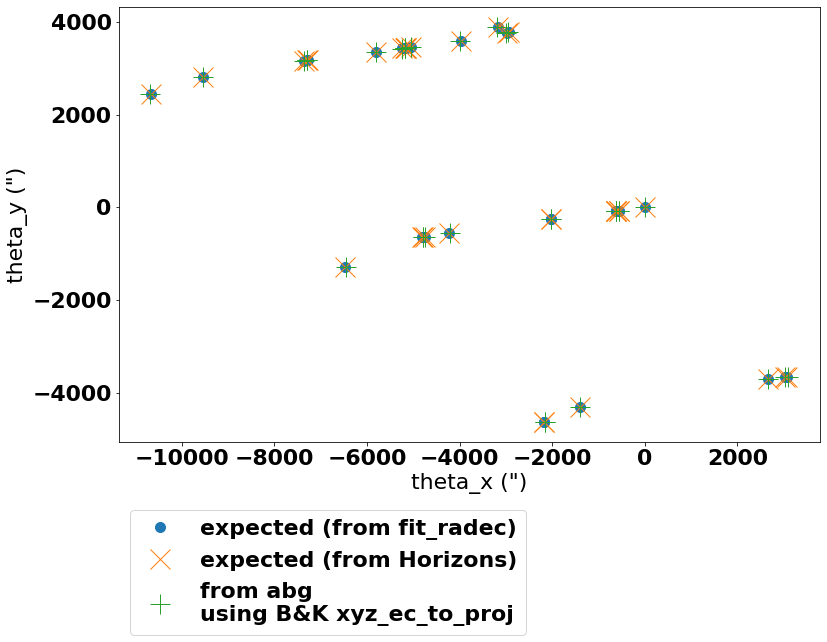

In [10]:
plt.rcParams['figure.figsize'] = [13, 8]
plt.plot(*expected_fitradec.T, '.', label='expected (from fit_radec)', ms=20)
#plt.plot(*thetas_asec_dot.T, '+', label='from abg, using projection matrix', ms=20)
plt.plot(*expected_thetas_asec.T, 'x', label='expected (from Horizons)', ms=20)
plt.plot(*thetas_asec.T, '+', label='from abg\nusing B&K xyz_ec_to_proj', ms=20)
plt.gca().set_aspect('equal')
plt.xlabel('theta_x (")')
plt.ylabel('theta_y (")')
plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))
plt.savefig('yay.png', bbox_inches='tight')

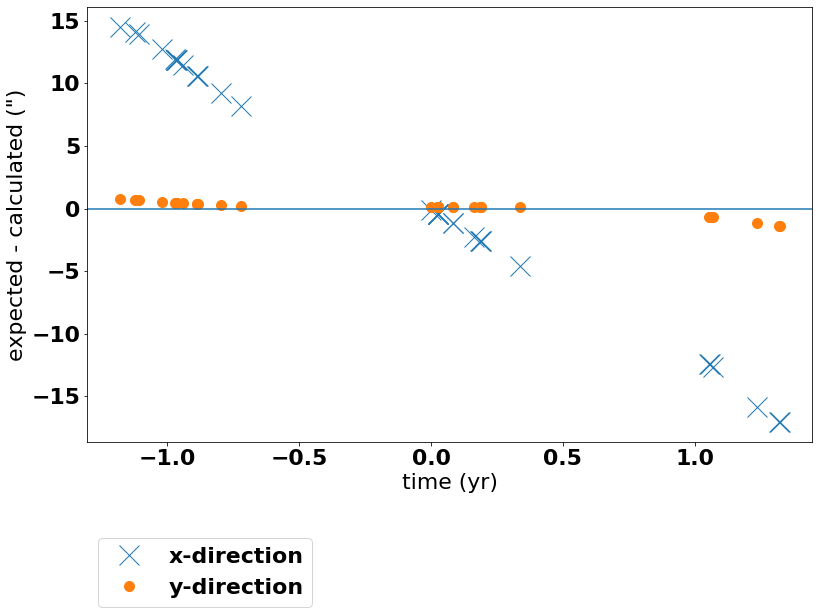

In [11]:
plt.rcParams['figure.figsize'] = [13, 8]
dtimes_yr = (times-time0)/365.24
plt.plot(dtimes_yr, (expected_thetas_asec - thetas_asec)[:, 0], 'x', label='x-direction', ms=20)
plt.plot(dtimes_yr, (expected_thetas_asec - thetas_asec)[:, 1], '.', label='y-direction', ms=20)
plt.axhline(0)
plt.ylabel('expected - calculated (")')
plt.xlabel('time (yr)')
plt.legend(loc='center left', bbox_to_anchor=(0, -0.3))
plt.savefig('yay.png', bbox_inches='tight')

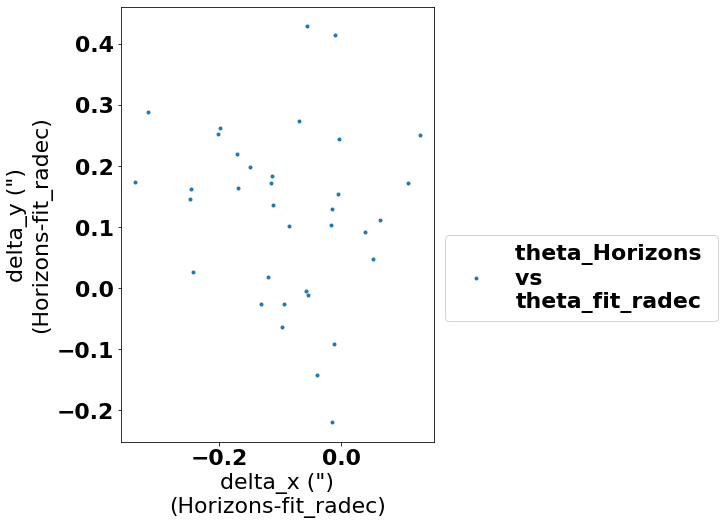

In [12]:
plt.plot(*(expected_thetas_asec-expected_fitradec).T, '.', label='theta_Horizons \nvs \ntheta_fit_radec')
plt.gca().set_aspect('equal')
plt.xlabel('delta_x (")\n(Horizons-fit_radec)')
plt.ylabel('delta_y (")\n(Horizons-fit_radec)')
plt.legend(bbox_to_anchor=(1, 0.5))

# Use ABG-derived thetas to shift+stack!

In [101]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
# I'm gonna define this flag, so that it's easy to switch between
# using both nights (24 images) and just the second night (12 images).
# Only the last 12 images are in GitHub repo.
#both_nights=False
both_nights=True
#Then define a bunch of filenames:
importlib.reload(imagehandler)
filename = '../dev_data/2015RS281_HSC20160826_112.fits'
if both_nights:
    filenames=[filename.replace('112', str(i)) for i in np.arange(100, 124)]
    filenames[:12]=[filenamei.replace('0826', '0825') for filenamei in filenames[:12]]
else:
    filenames=[filename.replace('112', str(i)) for i in np.arange(112, 124)]

In [102]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)

In [103]:
'''Get times and shifts (as calculated by Horizons)'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
shiftss = D._calculate_shifts_from_known(object_name='2015 RS281', obs_code='568')
shifts = shiftss - shifts[12] if both_nights else shiftss - shifts[-1]
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5

Combining images using median stacking.


80.61544

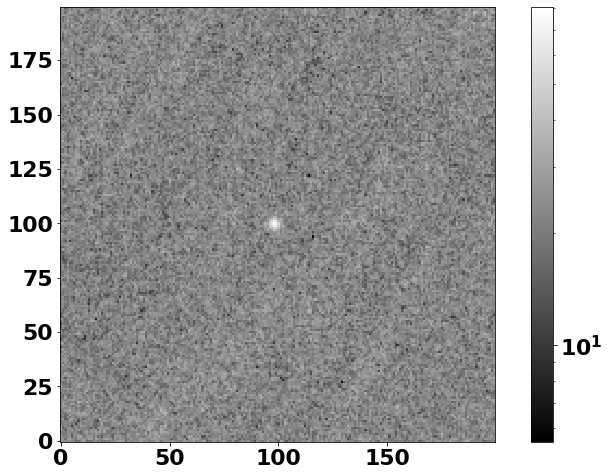

In [104]:
'''Shift+stack using the known (from Horizons + WCS) shifts.'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605])

In [105]:
'''
Get the position of the observer position. 
'''
# Observer's heliocentric ecliptic location at all times.
observer_helio_ecliptic = get_heliocentric_ecliptic_XYZ_from_JPL(times, '568')
# Observer's heliocentric equatorial location at reference times.
observer_helio_ecliptic0 = get_heliocentric_ecliptic_XYZ_from_JPL(time0, '568')
# Observer's equatorial location relative to the location at the reference time
observer_helio_ecliptic_relative = observer_helio_ecliptic - observer_helio_ecliptic0

In [106]:
'''
Convert observer location to projection coordinate system, then convert abg to thetas.
'''
observer_projected = np.array([xyz_ec_to_proj(*obspos, *latlon0) for obspos in observer_helio_ecliptic_relative])
# Theta from ABG values. These are in radians.
thetas = abg2theta(times, time0, abg, '568', observer_projected)
# Convert to arcseconds
thetas_asec = np.degrees(thetas) * 3600  # radians to arc-sec
# Convert to pixels
thetas_pixels = thetas_asec / 0.170  # This could be more accurate, but is pretty close. 
#thetas_pixels = thetas_asec / 0.168  # This seems better

In [110]:
'''Rotate thetas to CCD orientation'''
proj2ccd_angle = ECL        # Could be whatever, depending on camera orientation
#proj2ccd_angle = ECL*0.975  #In fact, this seems better
rotmat = np.array([[np.cos(proj2ccd_angle), -np.sin(proj2ccd_angle)],
                   [np.sin(proj2ccd_angle), np.cos(proj2ccd_angle)]])
rotated = np.array([rotmat.dot(fi) for fi in thetas_pixels])

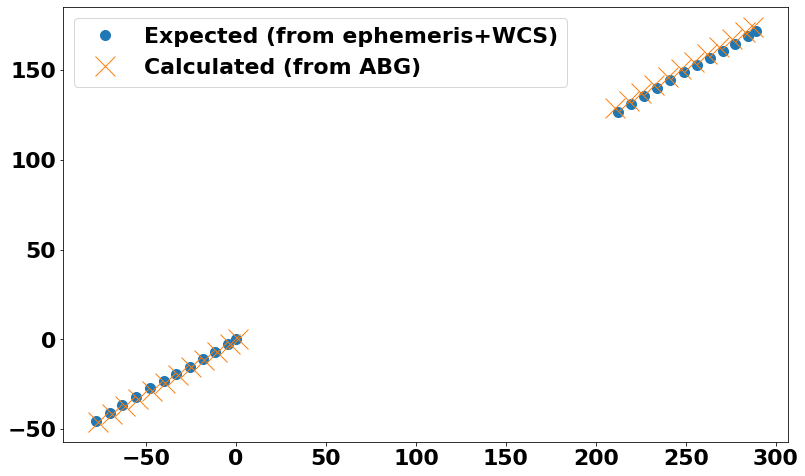

In [111]:
plt.plot(*shifts.T, '.', label='Expected (from ephemeris+WCS)', ms=20)
plt.plot(*(rotated).T, 'x', label='Calculated (from ABG)', ms=20)
#plt.plot(*(rotated-rotated[0]).T, 'x', label='Calculated (from ABG)', ms=20)
plt.legend()

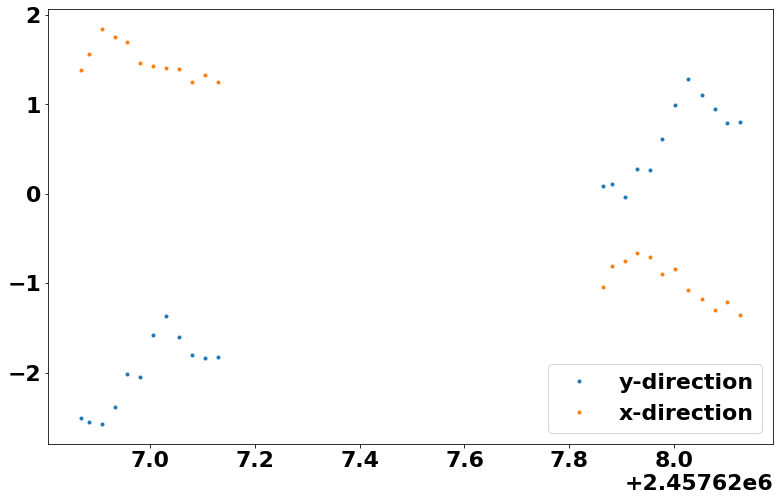

In [112]:
plt.plot(times, (shifts-rotated)[:, 1], '.', label='y-direction')
plt.plot(times, (shifts-rotated)[:, 0], '.', label='x-direction')
plt.legend()

Combining images using median stacking.


56.088135

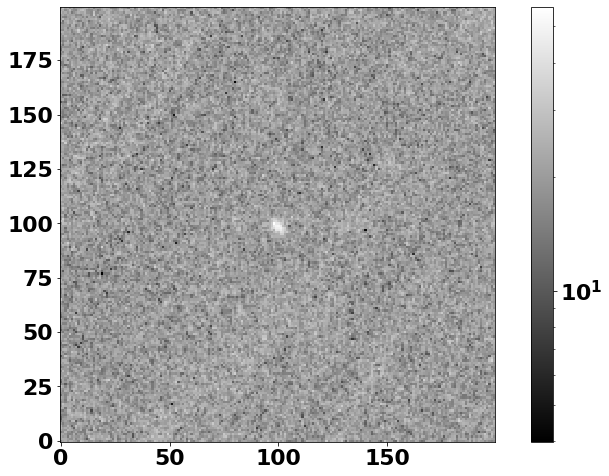

In [113]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames)
D.integer_shift(rotated, padmean=True)
D.stack(shifted=True, median_combine=True)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
np.max((D.stacked_data.data-np.nanmin(D.stacked_data.data))[520:720,405:605])